# PPT WebCrawler & Machine Learning

## Overview

1. Import Packages
2. Web Crawler
3. Data storage (ETL)
4. Feature Engineering
5. Data Visualization
6. Modeling
7. Prediction

## Import Packages

In [3]:
import time
from bs4 import BeautifulSoup
import requests
import pandas as pd
import openpyxl
import sqlite3


## Crawlering & Storage

In [2]:
"""Create database"""
def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except :
        print("Connection error")
    return conn

def create_table(conn, create_table):
    try:
        c = conn.cursor()
        c.execute(create_table)
        #c.commit()
    except :
        print("Create table error")

def main():
    database = "mydatabase1.db"
    # create a database connection
    conn = create_connection(database)

    sql_create_ptt_table_query = """ CREATE TABLE IF NOT EXISTS PTT (
                                        board text NOT NULL,
                                        id text,
                                        pushes text,
                                        author text,
                                        title text
                                    ); """
    
    # create tables
    if conn is not None:
        # create ptt table
        create_table(conn, sql_create_ptt_table_query)
    else:
        print("Error! cannot create the database connection.")

    conn.close()

main()


In [3]:
'''New Data'''
def add_new_row(insertlist):
    try:
        conn = sqlite3.connect('mydatabase1.db')
        cursor = conn.cursor()
        strinsertlist = "'"+"','".join(insertlist)+"'"
        #print(strinsertlist)
        add_new_row_query = """INSERT INTO PTT(board,id,pushes,author,title) VALUES("""+strinsertlist+""") """
        
        cursor.execute(add_new_row_query)
        conn.commit()
        #print("ok",insertlist)
        conn.close()
    except:
        print('?')
        print(insertlist)
        conn.close()



In [ ]:
"""用openpyxl寫進worksheet"""
wb = openpyxl.Workbook()
ws = wb.active
ws.append(["看板名稱",'id',"推文數","文章作者","文章名稱"]) 
#for board_name in ('NBA','Baseball'):
for board_name in ('NBA',"Stock",'Boy-Girl','Baseball',"Lifeismoney"):
    url = 'https://www.ptt.cc/bbs/'+board_name+'/index.html'
    for page in range(1,31): #30頁
        print(url)  #當前的url
        print(board_name,"版page",page)
        time.sleep(2)
        web = requests.get(url,cookies={'over18':'1'})
        soup = BeautifulSoup(web.text, "html.parser")
        pushes = soup.find_all('div',class_='nrec')
        authors = soup.find_all('div',class_='author')
        titles = soup.find_all('div', class_='title')     # 取得 class 為 title 的 div 內容
        for i,j,k in zip(titles,pushes,authors):
            if i.find('a') != None:                         # 判斷如果不為 None
                a = j.text
                #print(a,k.text,end=" ")        #推文數,作者
                #print(i.find('a').get_text())                 # 取得 div 裡 a 的內容，使用 get_text() 取得文字
                
                id = i.find('a').get("href")[i.find('a').get("href").find(board_name):i.find('a').get("href").find('.A.')]
                
                b=0
                
                if a =='爆':
                    url_article = "https://www.ptt.cc"+i.find('a').get('href')
                    web_article = requests.get(url_article,cookies={'over18':'1'})
                    soup_article = BeautifulSoup(web_article.text, "html.parser")
                    b=0
                    pushnumber = soup_article.find_all('div',class_='push')
                    for m in pushnumber:
                        if m.text[0] == '推':
                            b+=1
                        elif m.text[0] == '噓':
                            b-=1
                    #print("爆",b)
                #print([board_name,a,k.text,i.text])
                
                if b>0:
                    #print([board_name,str(b),k.text,i.text])
                    data = [board_name,id,str(b),k.text,i.text]
                    ws.append(data)
                    add_new_row(data)
                else:
                    #print([board_name,a,k.text,i.text])
                    data = [board_name,id,a,k.text,i.text]
                    ws.append(data)
                    add_new_row(data)

                

        url = "https://www.ptt.cc"+soup.find_all("a",class_='btn wide')[1].get('href') #上一頁的href

wb.save("PPT1.xlsx")


In [4]:
"""從sqlite撈取資料庫"""
conn = sqlite3.connect('mydatabase1.db')
cursor = conn.cursor()

df = pd.read_sql("SELECT board,title FROM PTT",conn)
conn.close()
print(df)

            board                                   title
0             NBA              \n[花邊] 到1/21為止所有球員TPA排行圖\n
1             NBA                         \n[公告] 板規10.1\n
2             NBA  \n[情報] SEASON Schedule January 22–23\n
3             NBA                         \n[公告] 板主徵選開始\n
4             NBA  \n[情報] NBA Standings (Jan. 22, 2023)\n
...           ...                                     ...
2923  Lifeismoney          \n[情報] 韓味不二 湯品鍋物7入禮盒 $968 免運\n
2924  Lifeismoney           \nRe: [新聞] 12月份壽星優惠 20大餐廳優惠\n
2925  Lifeismoney                 \n[情報] 統一精工2023上半年度活動\n
2926  Lifeismoney                       \n[情報] 熊好券 終極加碼\n
2927  Lifeismoney   \n[情報] EPIC《氣球塔防 6》免費 至 12/17 00:00\n

[2928 rows x 2 columns]


## Data Overview

In [6]:
df.head()

,board,title
0,NBA,\n[花邊] 到1/21為止所有球員TPA排行圖\n
1,NBA,\n[公告] 板規10.1\n
2,NBA,\n[情報] SEASON Schedule January 22–23\n
3,NBA,\n[公告] 板主徵選開始\n
4,NBA,"\n[情報] NBA Standings (Jan. 22, 2023)\n"


In [10]:
df.describe()

,board,title
count,2928,2928
unique,5,2531
top,Lifeismoney,\nRe: [討論] 為何男生不會追求儀式感？\n
freq,592,32


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2928 entries, 0 to 2927
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   board   2928 non-null   object
 1   title   2928 non-null   object
dtypes: object(2)
memory usage: 45.9+ KB


In [60]:
# Number of post on each board
board_count={}
for i in df['board'].unique():
    board_count[i] = list(df['board']).count(i)
print(board_count)

{'NBA': 575, 'Stock': 574, 'Boy-Girl': 582, 'Baseball': 586, 'Lifeismoney': 578}


## Feature Engineering

1. '\n' in title
3. drop 公告
2. jieba

In [24]:
# '\n'
for i in range(len(df)):
    df['title'][i] = df['title'][i].replace('\n','')

In [59]:
# 公告
for i in range(len(df)):
    if ("[公告]" in df['title'][i]):
        print(df['title'][i])
        df = df.drop(i)
df = df.reset_index(drop=True)

In [ ]:
#jieba
import jieba
def cut_text(text):
    cut = jieba.cut(text)
    return list(cut) 
df['text'] = df['title'].apply(cut_text)

## Data Visualization

<AxesSubplot: xlabel='board'>

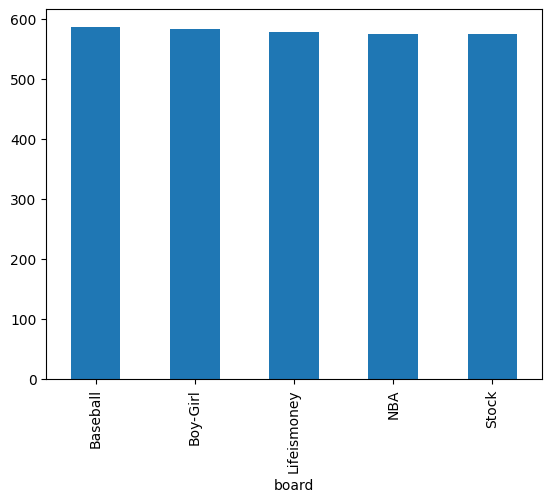

In [73]:
groups = df.groupby('board')
groups.size().plot(kind='bar')

In [ ]:
# Word Cloud (by board)

